# Building a Risk Parity Portfolio
This notebook fetches historical monthly closing prices of key financial futures, calculates returns, builds an risk parity portfolio, and assesses its performance.

## Importing Necessary Libraries
First, we import the required Python libraries for data fetching, manipulation, and visualization.

In [31]:
import yfinance as yf  # Import Yahoo Finance API for fetching market data
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
import matplotlib.dates as mdates  # Import date formatting utilities for plots
import matplotlib.ticker as ticker  # Import ticker module for axis formatting
import numpy as np  # Import NumPy for numerical operations

## Defining Financial Assets
We specify the financial futures to analyze, including the S&P 500 E-mini, 10-Year Treasury Note, Gold, and Dollar Index.

In [32]:
tickers = ["ES=F", "ZN=F", "GC=F", "DX=F"]

## Downloading and Preprocessing Data
We fetch historical adjusted closing prices for the selected tickers, forward-fill missing values, and resample the data to obtain monthly closing prices.

In [33]:
prices = yf.download(tickers)["Close"]
prices = prices.ffill().dropna()  # Forward-fill missing values and drop NaNs
prices = prices.resample("ME").last()  # Resample data to get monthly end-of-period prices
print(prices)

[*********************100%***********************]  4 of 4 completed


Ticker            DX=F     ES=F         GC=F        ZN=F
Date                                                    
2000-09-30  113.000000  1454.00   273.600006  100.218803
2000-10-31  116.620003  1440.75   264.899994  100.703102
2000-11-30  115.099998  1321.00   270.100006  102.703102
2000-12-31  109.279999  1327.00   272.000000  104.890602
2001-01-31  110.529999  1373.50   265.600006  105.484398
...                ...      ...          ...         ...
2024-10-31  103.877998  5738.50  2738.300049  110.468750
2024-11-30  105.828003  6051.50  2657.000000  111.015625
2024-12-31  108.295998  5935.75  2629.199951  108.750000
2025-01-31  108.217003  6067.25  2812.500000  108.843750
2025-02-28  108.099998  6086.00  2933.899902  109.312500

[294 rows x 4 columns]


## Calculating Monthly Returns
We compute percentage returns for each asset and remove missing values.

In [34]:
returns = prices.pct_change().dropna()
print(returns)

Ticker          DX=F      ES=F      GC=F      ZN=F
Date                                              
2000-10-31  0.032035 -0.009113 -0.031798  0.004832
2000-11-30 -0.013034 -0.083116  0.019630  0.019860
2000-12-31 -0.050565  0.004542  0.007034  0.021299
2001-01-31  0.011439  0.035041 -0.023529  0.005661
2001-02-28  0.013300 -0.095741  0.004518  0.008147
...              ...       ...       ...       ...
2024-10-31  0.033396 -0.013028  0.038769 -0.033361
2024-11-30  0.018772  0.054544 -0.029690  0.004950
2024-12-31  0.023321 -0.019127 -0.010463 -0.020408
2025-01-31 -0.000729  0.022154  0.069717  0.000862
2025-02-28 -0.001081  0.003090  0.043164  0.004307

[293 rows x 4 columns]


## Constructing a Risk Parity Portfolio

In this section of the code, we compute portfolio weights based on the **risk parity principle**, which aims to equalize the contribution of each asset to the total portfolio risk. This is done by calculating weights inversely proportional to the assets' rolling volatility.

### Key Steps in the Code:
1. **Function Definition (`compute_risk_parity_weights`)**:
   - The function calculates risk parity weights for a portfolio based on the historical returns of its assets.
   - It uses a rolling window approach to compute the volatility of each asset.

2. **Rolling Volatility (`rolling_vol`)**:
   - Rolling standard deviations are calculated for each asset over the specified window size (default: 36 periods).
   - This represents the recent risk (volatility) of each asset.

3. **Inverse Volatility (`rolling_inverse_vol`)**:
   - The inverse of the rolling volatility is calculated for each asset.
   - Assets with lower volatility get higher inverse values, reflecting a lower risk profile.

4. **Normalization (`risk_parity_weights`)**:
   - The inverse volatility values are normalized so that the sum of all weights equals 1.
   - This ensures the portfolio is fully invested.

5. **Shift to Avoid Look-Ahead Bias**:
   - The weights are shifted by one period to prevent future data from influencing the results.

6. **Return Risk Parity Weights**:
   - The function returns a DataFrame containing the risk parity weights for each asset over time.

7. **Application to Portfolio Returns**:
   - The computed risk parity weights are applied to the asset returns to calculate the **risk-parity-weighted portfolio returns**.

### Example Output:
- `risk_parity_weights`: A DataFrame where each column represents the rolling risk parity weights for an asset over time.
- `risk_parity_weighted_returns`: A series of portfolio returns calculated by applying the risk parity weights.

### Why Risk Parity?
- Risk parity is widely used in portfolio management to balance risk contributions among assets.
- It ensures diversification by allocating more weight to less volatile assets, thus stabilizing overall portfolio performance.

This methodology allows for a robust and risk-aware approach to portfolio construction. Below is the implementation of the process:


In [35]:
def compute_risk_parity_weights(returns, window_size=36):
    """
    Computes rolling risk parity weights for a portfolio based on historical returns.

    Risk parity aims to allocate portfolio weights such that each asset contributes equally to overall portfolio risk.
    This function calculates weights by inverting the rolling standard deviation of each asset.

    Args:
        returns (pd.DataFrame): A DataFrame of asset returns (columns are assets, rows are time periods).
        window_size (int): The size of the rolling window (in periods) used to calculate volatility. Defaults to 36.

    Returns:
        pd.DataFrame: A DataFrame of risk parity weights for each asset over time, shifted by one period to avoid look-ahead bias.
    """
    # Calculate the rolling standard deviation (volatility) for each asset over the specified window size
    rolling_vol = returns.rolling(window_size).std()

    # Compute the inverse of the rolling volatility for each asset
    rolling_inverse_vol = 1 / rolling_vol

    # Normalize the inverse volatilities to sum to 1 for risk parity weights
    risk_parity_weights = rolling_inverse_vol.apply(
        lambda column: column / rolling_inverse_vol.sum(axis=1)  # Divide each asset's inverse vol by the total
    )

    # Print the type of the calculated weights (for debugging purposes)
    print(type(risk_parity_weights))

    # Shift the weights by one period to avoid look-ahead bias
    risk_parity_weights = risk_parity_weights.shift(1)

    # Return the risk parity weights DataFrame
    return risk_parity_weights


# Compute risk parity weights using a rolling window of 36 periods
risk_parity_weights = compute_risk_parity_weights(returns, 36)

# Apply the computed risk parity weights to the returns to get weighted portfolio returns
risk_parity_weighted_returns = (returns * risk_parity_weights).sum(axis=1)


<class 'pandas.core.frame.DataFrame'>


## Computing Performance Metrics for Financial Returns

In this section, we define the `compute_performance` function, which calculates key performance metrics for a given time series of financial returns. This function is essential for evaluating portfolio performance, understanding risk-adjusted returns, and identifying potential risks.

### What This Function Does:
- **Annualized Mean Return**: Computes the expected yearly return based on the average of historical returns.
- **Annualized Volatility**: Measures the standard deviation of returns, scaled to an annual basis.
- **Skewness & Kurtosis**: Assess the distribution of returns to identify asymmetry and extreme tail events.
- **Information Ratio**: Evaluates the return-to-risk tradeoff by comparing excess return over volatility.
- **Cumulative Returns**: Tracks the total compounded growth of an investment over time.
- **Drawdowns & Max Drawdown**: Identifies the worst peak-to-trough decline in portfolio value.
- **Downside Volatility**: Measures risk only from negative returns, giving a more accurate risk assessment.
- **Sortino & Calmar Ratios**: Provide risk-adjusted return measures focusing on downside risk and drawdowns.

These metrics help investors and analysts assess performance, optimize portfolios, and mitigate financial risks.

Next, we implement this function in Python.


In [36]:
def compute_performance(returns, freq):
    """
    Computes key performance metrics for a financial time series.
    
    Args:
        returns (pd.Series): Time series of portfolio returns.
        freq (int): Frequency of returns (e.g., 12 for annualized calculations).
    
    Returns:
        dict: A dictionary containing computed performance metrics.
    """
    annual_mean_return = returns.mean() * freq
    annual_volatility = returns.std() * np.sqrt(freq)
    cumulative_returns = (1 + returns).cumprod()
    drawdowns = (cumulative_returns.cummax() - cumulative_returns) / cumulative_returns.cummax()
    downside_volatility = returns[returns < 0].std() * np.sqrt(freq)

    performance_metrics = {
        "annual_mean_return": annual_mean_return,
        "annual_volatility": annual_volatility,
        "skewness": returns.skew(),
        "kurtosis": returns.kurt(),
        "information_ratio": annual_mean_return / annual_volatility,
        "cumulative_returns": cumulative_returns,
        "drawdowns": drawdowns,
        "max_drawdown": drawdowns.max(),
        "downside_volatility": downside_volatility,
        "sortino_ratio": annual_mean_return / downside_volatility,
        "calmar_ratio": annual_mean_return / drawdowns.max()
    }
    return performance_metrics


In [37]:
# Compute performance metrics
risk_parity_portfolio_metrics = compute_performance(risk_parity_weighted_returns, 12)



## Displaying Key Performance Metrics

Once we have computed the performance metrics for our financial time series, the next step is to present them in a structured and readable format. This is accomplished using the `print_metrics` function.

### What This Function Does:
- It takes a **dictionary** of computed performance metrics as input.
- **Formats and prints** each key metric in a human-readable way.
- Includes essential statistics such as:
  - **Annualized Mean Return**: The expected return per year.
  - **Annualized Volatility**: A measure of risk based on standard deviation.
  - **Skewness & Kurtosis**: Used to assess the shape of the return distribution.
  - **Information Ratio**: Evaluates the return in relation to risk.
  - **Max Drawdown**: The worst peak-to-trough loss.
  - **Downside Volatility**: Measures only negative return fluctuations.
  - **Sortino & Calmar Ratios**: Provide risk-adjusted return metrics.

By structuring performance data in a clear and concise manner, this function makes it easier to analyze and interpret financial performance.

Next, we call this function to display our portfolio’s key statistics.


In [38]:
def print_metrics(performance_metrics):
    """
    Prints key performance metrics in a readable format.
    
    Args:
        performance_metrics (dict): Dictionary containing performance metrics.
    """
    print(f"Annual Mean Return: {performance_metrics['annual_mean_return']:.1%}")
    print(f"Annual Volatility: {performance_metrics['annual_volatility']:.1%}")
    print(f"Skewness: {performance_metrics['skewness']:.1f}")
    print(f"Kurtosis: {performance_metrics['kurtosis']:.1f}")
    print(f"Information Ratio: {performance_metrics['information_ratio']:.1f}")
    print(f"Max Drawdown: {performance_metrics['max_drawdown']:.1%}")
    print(f"Downside Volatility: {performance_metrics['downside_volatility']:.1%}")
    print(f"Sortino Ratio: {performance_metrics['sortino_ratio']:.1f}")
    print(f"Calmar Ratio: {performance_metrics['calmar_ratio']:.1f}")


In [39]:
# Print performance metrics
print_metrics(risk_parity_portfolio_metrics)



Annual Mean Return: 3.0%
Annual Volatility: 3.4%
Skewness: 0.3
Kurtosis: 1.6
Information Ratio: 0.9
Max Drawdown: 5.0%
Downside Volatility: 2.1%
Sortino Ratio: 1.5
Calmar Ratio: 0.6


## Visualizing Portfolio Performance

After computing and printing the key financial metrics, the next step is to visualize the performance of our portfolio using the `plot_performance` function.

### What This Function Does:
- **Plots cumulative returns**: This line graph shows how the portfolio’s value has grown over time.
- **Tracks cumulative maximum returns**: Helps in visualizing the highest portfolio value achieved historically.
- **Highlights drawdowns**: Indicates periods where the portfolio’s value declined from its peak.
- **Uses clear labeling and formatting**: The chart is designed with gridlines, legends, and axis formatting for better readability.

### Why Visualization Matters:
- It provides **insights into trends and volatility** in portfolio performance.
- Helps **identify major drawdown periods**, which are crucial for risk management.
- Aids in **comparing portfolio returns** with benchmarks or alternative strategies.

Next, we call this function to generate an interactive plot of our portfolio's historical performance.


In [40]:
def plot_performance(performance_metrics):
    """
    Plots cumulative returns and drawdowns over time.
    
    Args:
        performance_metrics (dict): Dictionary containing performance metrics.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(performance_metrics['cumulative_returns'] - 1, label="Cumulative Returns")
    plt.plot(performance_metrics['cumulative_returns'].cummax() - 1, label="Cumulative Max")
    plt.fill_between(
        performance_metrics['drawdowns'].index, 
        -performance_metrics['drawdowns'],
        color="red", 
        alpha=0.3,
        label="Drawdowns"
        )
    plt.grid()
    plt.legend()
    plt.title("Cumulative Returns Over Time")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return / Drawdown")
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.xticks(rotation=45)
    plt.show()



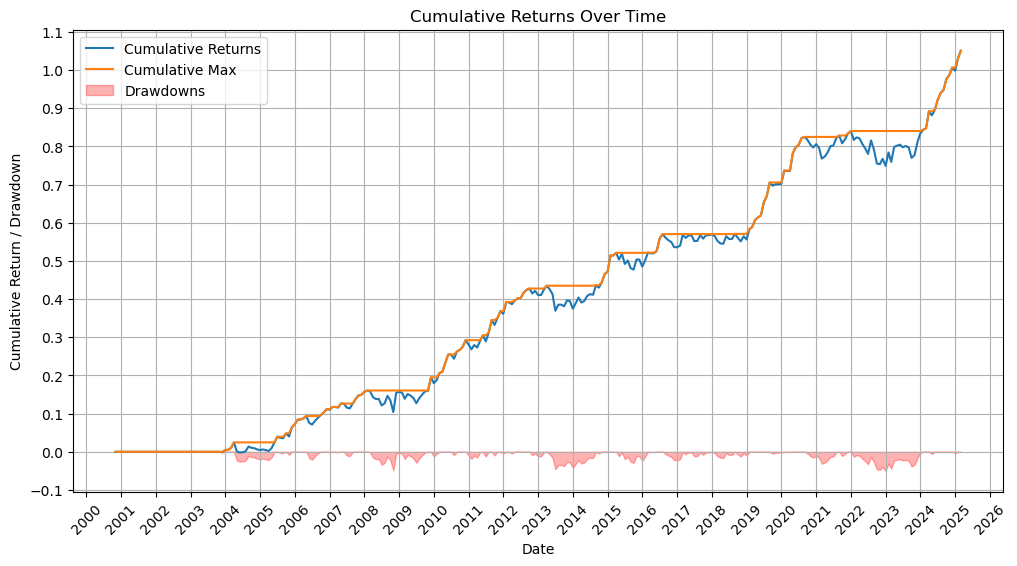

In [41]:
# Plot performance metrics
plot_performance(risk_parity_portfolio_metrics)